# Logarithm

Here we analyse how accurate are the approximate functions for Logarithm

We compare Newton Raphson & 6th order HouseHolder

### Define a benchmark method

In [1]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [2]:
import torch as th
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def benchmark(real_func, approx_func, interval, n_points=100, approx_kwargs={}, forward_transformer=lambda x:x, backward_transformer=lambda x:x):
    """
    Benchmark an approximation function compared to an exact function.
    Compute and print the relative divergence
    
    Args:
        real_func: 
        approx_func: 
        interval: 
        n_points: 
        approx_kwargs: optional kwargs to provide to the approximation function
        forward_transformer: optional input transformation to apply before calling approx_func
        backward_transformer: optional output transformation to apply after calling approx_func
    """
    start, stop = interval
    points = np.linspace(start, stop, num=n_points)
    real_values = []
    approx_values = []
    for x in points:
        x = th.tensor([x])
        real_value = real_func(x)
        real_values.append(real_value.item())
        x_syft = forward_transformer(x)
        #print(x_syft.child.child.virtual_get())
        approx_value_syft = approx_func(x_syft, **approx_kwargs)
        #print(approx_value_syft.child.child.virtual_get())
        approx_value = backward_transformer(approx_value_syft)
        approx_values.append(approx_value.item())
        
    real_values = np.array(real_values)
    approx_values = np.array(approx_values)
        
    plt.plot(points, real_values)
    plt.plot(points, approx_values)
    plt.show()
    
    norm_diff = 2 * np.abs(real_values - approx_values)/(real_values + approx_values)
    plt.plot(points, norm_diff)
    plt.show()

## 1. Using the Newton Raphson method

In [17]:
from funcs import log_newton, log_householder

## 1.A Approximation alone

We analyse here the loss incurred by the approximation using only normal pytorch tensors

In [5]:
if not hasattr(th, 'native_exp'):
    th.native_exp = th.exp
    def hook_exp(x, **kwargs):
        return th.native_exp(x)

    th.exp = hook_exp
    th.Tensor.refresh = lambda x:x

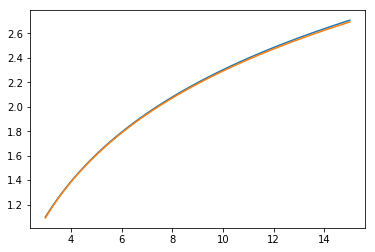

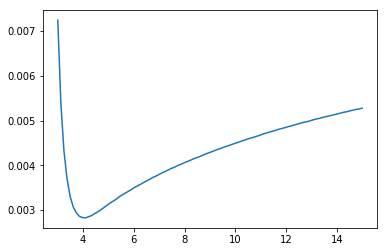

In [6]:
benchmark(
    th.log, 
    log_newton,
    interval = (3, 15), 
    approx_kwargs={'iterations': 3}
)

## 1.B Approximation with AdditiveSharingTensors

In [7]:
import syft as sy
hook = sy.TorchHook(th)

bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")
charlie = sy.VirtualWorker(hook, id="charlie")
crypto = sy.VirtualWorker(hook, id="crypto_provider")

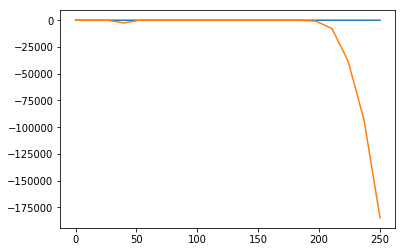

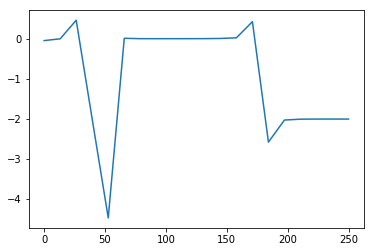

In [18]:
benchmark(
    th.log, 
    log_newton, 
    interval = (0.1, 250), 
    n_points=20,
    approx_kwargs={'iterations': 2, 'exp_iterations': 8},
    forward_transformer=lambda x: x.fix_precision(precision_fractional=5).share(alice, bob, crypto_provider=crypto),
    backward_transformer=lambda x: x.get().float_precision()
)

Interestingly here, the approximation only works on a given range, roughly $[70:160]$ 

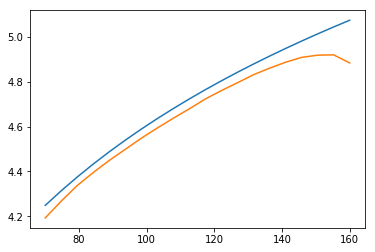

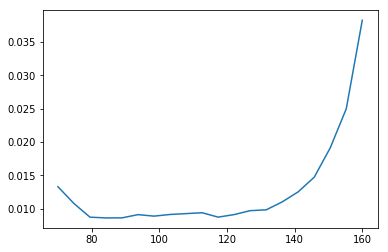

In [19]:
benchmark(
    th.log, 
    log_newton, 
    interval = (70, 160), 
    n_points=20,
    approx_kwargs={'iterations': 2, 'exp_iterations': 8},
    forward_transformer=lambda x: x.fix_precision(precision_fractional=5).share(alice, bob, crypto_provider=crypto),
    backward_transformer=lambda x: x.get().float_precision()
)

With more iterations $2 \rightarrow 8$, results are a bit better but are much more expensive to compute:

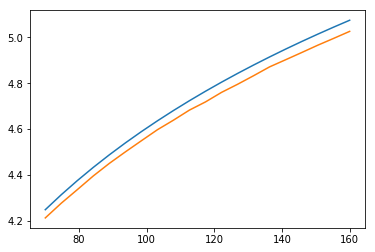

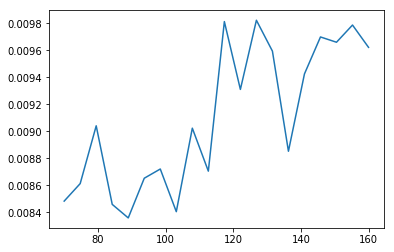

In [23]:
benchmark(
    th.log, 
    log_newton, 
    interval = (70, 160), 
    n_points=20,
    approx_kwargs={'iterations': 8, 'exp_iterations': 8},
    forward_transformer=lambda x: x.fix_precision(precision_fractional=5).share(alice, bob, crypto_provider=crypto),
    backward_transformer=lambda x: x.get().float_precision()
)

### Remarks
- The approximation and its range of validity depends on the initialization chosen

Here is an alternate initialization

In [30]:
from funcs import exp
def log_newton(x, iterations=2, exp_iterations=8):
    """Approximates the logarithm using the Newton Raphson method

    Args:
        iterations (int): number of iterations for Newton Raphson approximation.
        exp_iterations (int): number of iterations for limit approximation of exp

    .. inspired by https://github.com/facebookresearch/CrypTen
    """
    # PREVIOUS: 
    y = x / 40 + 1.9 - 8 * exp(-2 * x - 0.3, iterations=exp_iterations)
    # NEW:
    #y = x / 120 - 20 * exp(-2 * x - 1.0, iterations=exp_iterations) + 3.0

    for i in range(iterations):
        h = [1 - x * exp((-y).refresh(), iterations=exp_iterations)]
        for i in range(1, 5):
            h.append(h[-1] * h[0])

        y -= h[0] * (1 + h[0] + h[1] + h[2] + h[3] + h[4])

    return y

The field of validity is now very different!

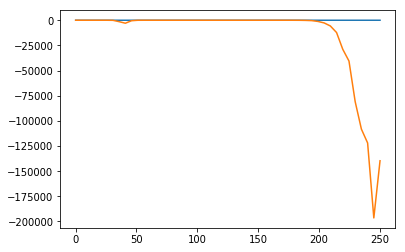

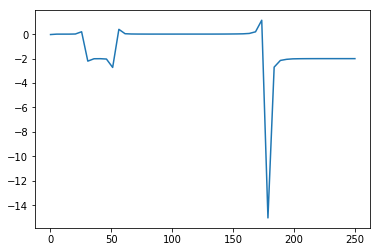

In [34]:
benchmark(
    th.log, 
    log_newton, 
    interval = (0.1, 250), 
    n_points=50,
    approx_kwargs={'iterations': 2, 'exp_iterations': 8},
    forward_transformer=lambda x: x.fix_precision(precision_fractional=5).share(alice, bob, crypto_provider=crypto),
    backward_transformer=lambda x: x.get().float_precision()
)

On $[5:23]$:

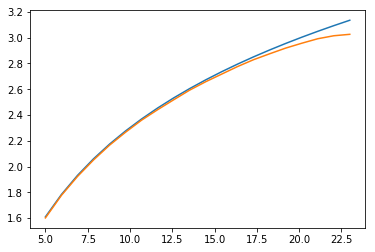

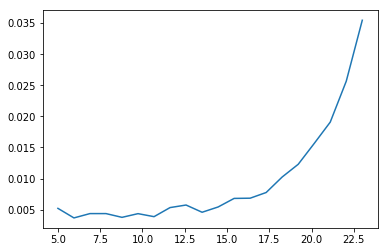

In [36]:
benchmark(
    th.log, 
    log_newton, 
    interval = (5, 23), 
    n_points=20,
    approx_kwargs={'iterations': 2, 'exp_iterations': 8},
    forward_transformer=lambda x: x.fix_precision(precision_fractional=5).share(alice, bob, crypto_provider=crypto),
    backward_transformer=lambda x: x.get().float_precision()
)

The reason for this is that Newton's method is really instable, in section 2 we study the HouseHolder method which is a better fit for this task.

# 2. Using the HouseHolder method

## 1.A Approximation alone

We analyse here the loss incurred by the approximation using only normal pytorch tensors

TBD